# Pokemon Grass vs Water vs Fire Classifier

### Importing libraries and read csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras as ks

from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../input/pokemon-images-and-types/pokemon.csv')
df.shape

(809, 3)

In [3]:
df.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


### lets sort the pokemons names in order to keep in match with the available image files

In [4]:
df2 = df.sort_values(by=['Name'], ascending=True).reset_index(drop=True)
df2.head()

,Name,Type1,Type2
0,abomasnow,Grass,Ice
1,abra,Psychic,NaN
2,absol,Dark,NaN
3,accelgor,Bug,NaN
4,aegislash-blade,Steel,Ghost


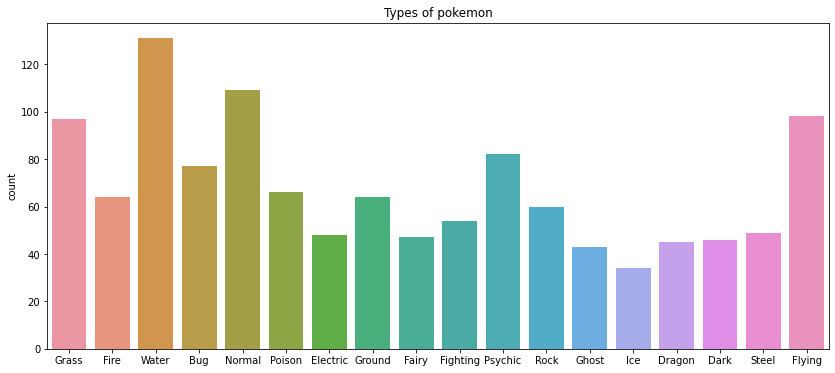

In [5]:
type1 = df['Type1'].tolist()
type2 = df['Type2'].tolist()

typo = type1 + type2

plt.figure(figsize=(14, 6))

sns.countplot(x=typo)
plt.title('Types of pokemon')
plt.show()

In [6]:
x1 = df.Type1.value_counts().keys()
y1 = df.Type1.value_counts().values
x2 = df.Type2.value_counts().keys()
y2 = df.Type2.value_counts().values

In [7]:
xy1 = pd.DataFrame({'x1':x1, 'y1':y1})
xy2 = pd.DataFrame({'x2':x2, 'y2': y2})
xy1.sort_values(by=['x1'],ascending=True, inplace=True)
xy2.sort_values(by=['x2'],ascending=True, inplace=True)

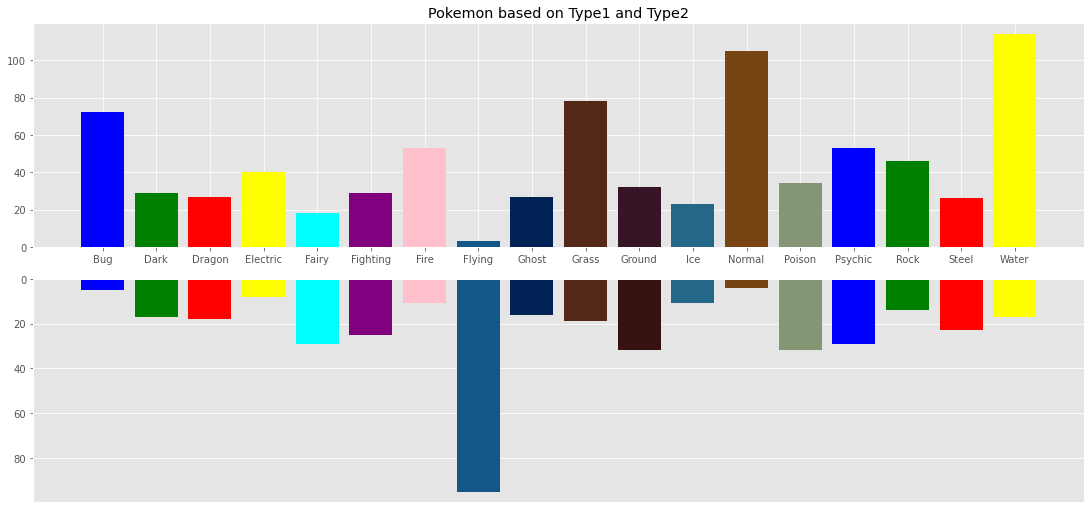

In [8]:
plt.style.use('ggplot')
plt.figure(figsize=(30, 7))
gspec = gridspec.GridSpec(2, 2)
tp = plt.subplot(gspec[0, 1])
bt = plt.subplot(gspec[1, 1:])

tp.bar(xy1.x1,xy1.y1, color=['blue', 'green', 'red',
                             'yellow', 'cyan', 'purple',
                             'pink', '#135688', '#002255',
                             '#532819', '#381526', '#256789',
                            '#784512', '#859674'])
bt.bar(xy2.x2, xy2.y2, color=['blue', 'green', 'red',
                             'yellow', 'cyan', 'purple',
                             'pink', '#135688', '#002255',
                             '#532819', '#381111', '#256789',
                            '#784512', '#859674'])
bt.invert_yaxis()
bt.set_xticks([])
plt.tight_layout()
tp.set_title('Pokemon based on Type1 and Type2')
plt.show()

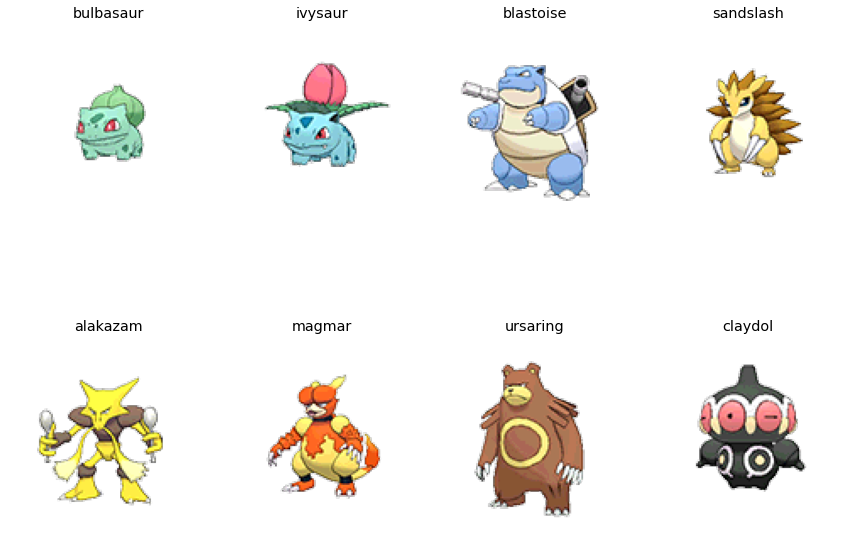

In [9]:
path = '../input/pokemon-images-and-types/images/images/'
fig,((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(12, 10))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for i in range(8):
    img = mpimg.imread(path+df['Name'][i**3]+'.png')
    ax[i].imshow(img)
    ax[i].set_title(df['Name'][i**3])
    ax[i].axis('off')
plt.tight_layout()
plt.show()
    

### Image Path Dataframe 

In [10]:
path='../input/pokemon-images-and-types/images/images/'
img_name = sorted(os.listdir('../input/pokemon-images-and-types/images/images/'))
img_paths = []
for i in img_name:
    img_paths.append(path + i)

In [11]:
df2['filepath'] = img_paths

In [12]:
poke_type = []
code = []

for i in range(df2.shape[0]):
    if (df2.iloc[i]['Type1']=='Grass') or (df2.iloc[i]['Type2']=='Grass'):
        poke_type.append('Grass')
        code.append(1)
    elif (df2.iloc[i]['Type1']=='Water') or (df2.iloc[i]['Type2']=='Water'):
        poke_type.append('Water')
        code.append(2)
    elif (df2.iloc[i]['Type1']=='Fire') or (df2.iloc[i]['Type2']=='Fire'):
        poke_type.append('Fire')
        code.append(3)
    else:
        poke_type.append('NaN')
        code.append('NaN')

In [13]:
df2['type'] = poke_type
df2['code'] = code
new_df = df2.drop(['Type1', 'Type2', 'Name'], axis=1)
new_df = new_df[new_df['type']!='NaN']
new_df.reset_index(drop=True, inplace=True)


In [14]:
new_df.head(2)

,filepath,type,code
0,../input/pokemon-images-and-types/images/image...,Grass,1
1,../input/pokemon-images-and-types/images/image...,Water,2


Text(0, 0.5, 'Number of images')

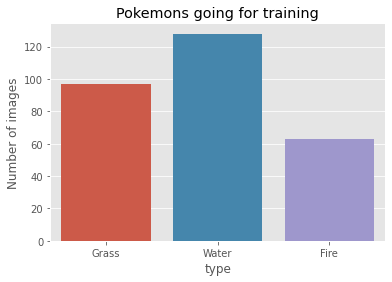

In [15]:
sns.countplot(x=new_df.type)
plt.title('Pokemons going for training')
plt.ylabel('Number of images')

## Augmentation

In [16]:
train_datagen = ImageDataGenerator(
    
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode='nearest',
    validation_split=0.1
)


train_generator = train_datagen.flow_from_dataframe(
    new_df, 
    x_col='filepath', y_col='type',
    target_size=(120, 120), 
    color_mode='rgba', 
    class_mode='categorical', 
    batch_size=32, 
    shuffle=True, 
    seed=1,
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    new_df , x_col='filepath', y_col='type',
    target_size=(120, 120),
    color_mode='rgba', 
    class_mode='categorical', 
    batch_size=4, 
    shuffle=True,
    seed=1, 
    subset='validation'
)

Found 260 validated image filenames belonging to 3 classes.
Found 28 validated image filenames belonging to 3 classes.


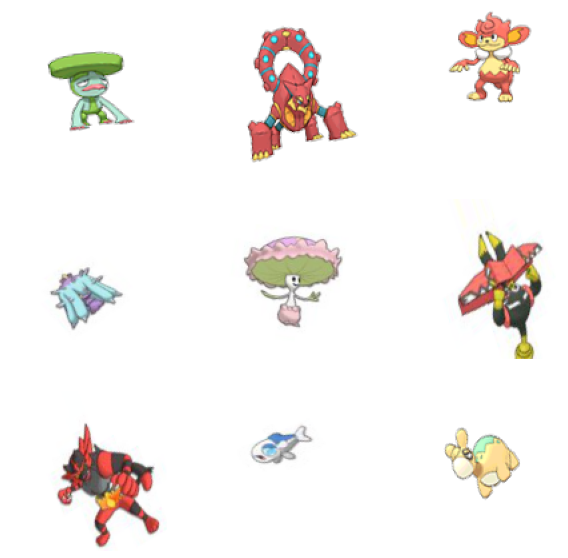

In [17]:
image_sample = train_generator.next()[0]

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(image_sample[i, :, :, :])
    plt.axis('off')
plt.show()

## Model

In [18]:
model = ks.models.Sequential()

model.add(ks.layers.Dense(4, input_shape=(120, 120, 4)))

model.add(ks.layers.Conv2D(64, (7, 7), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))
#model.add(ks.layers.Dropout(0.2))

model.add(ks.layers.Conv2D(128, (7, 7), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))
#model.add(ks.layers.Dropout(0.2))


model.add(ks.layers.Conv2D(256, (7, 7), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))
#model.add(ks.layers.Dropout(0.2))

model.add(ks.layers.Conv2D(512, (7, 7), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))
model.add(ks.layers.Dropout(0.2))


model.add(ks.layers.Flatten())

model.add(ks.layers.Dense(1024, activation='relu'))

model.add(ks.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120, 120, 4)       20        
_________________________________________________________________
conv2d (Conv2D)              (None, 114, 114, 64)      12608     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 57, 57, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 51, 51, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 256)       1605888   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 256)         0

In [20]:
model.layers

### Callback to stop the training when a particular accuarcy is reached

In [21]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.7) and (logs.get('val_acc')>0.7):
            print('\n reached 70% accuarcy so stopping training')
            self.model.stop_training = True
callbacks = myCallback()


In [22]:
history = model.fit(
    train_generator, 
    validation_data=validation_generator,
    batch_size=20, 
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(), 
        callbacks
    ]
    
)


Epoch 1/100
9/9 [==============================] - 7s 381ms/step - loss: 2.4507 - acc: 0.3715 - val_loss: 1.0877 - val_acc: 0.4643
Epoch 2/100
9/9 [==============================] - 2s 274ms/step - loss: 1.0862 - acc: 0.4357 - val_loss: 1.0717 - val_acc: 0.4286
Epoch 3/100
9/9 [==============================] - 2s 205ms/step - loss: 1.0628 - acc: 0.4862 - val_loss: 1.0446 - val_acc: 0.4286
Epoch 4/100
9/9 [==============================] - 2s 203ms/step - loss: 1.0502 - acc: 0.4359 - val_loss: 1.0460 - val_acc: 0.3214
Epoch 5/100
9/9 [==============================] - 2s 241ms/step - loss: 1.0445 - acc: 0.4126 - val_loss: 1.0478 - val_acc: 0.4286
Epoch 6/100
9/9 [==============================] - 2s 206ms/step - loss: 1.0627 - acc: 0.4276 - val_loss: 1.0544 - val_acc: 0.4286
Epoch 7/100
9/9 [==============================] - 2s 230ms/step - loss: 1.0541 - acc: 0.4118 - val_loss: 1.0555 - val_acc: 0.4286
Epoch 8/100
9/9 [==============================] - 2s 206ms/step - loss: 1.0279 - a

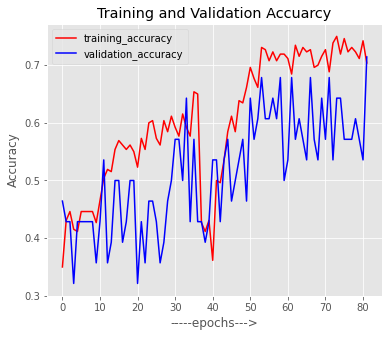

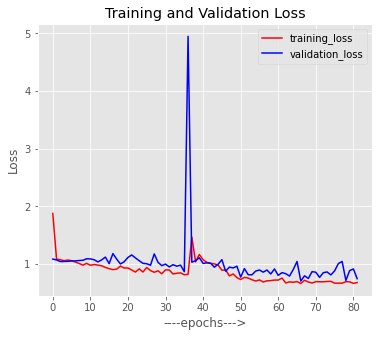

In [23]:
plt.style.use('ggplot')

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(6, 5))

plt.plot(epochs, acc, 'r', label='training_accuracy')
plt.plot(epochs, val_acc, 'b', label='validation_accuracy')
plt.title('Training and Validation Accuarcy')
plt.xlabel('-----epochs--->')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(6, 5))

plt.plot(epochs, loss, 'r', label='training_loss')
plt.plot(epochs, val_loss, 'b', label='validation_loss')
plt.title('Training and Validation Loss')
plt.xlabel('----epochs--->')
plt.ylabel('Loss')
plt.legend()

plt.show()